In [52]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

In [53]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [54]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.zeros((2, 2))
        self.a[0,:] = vertices[1,:] - vertices[0,:]
        self.a[1,:] = vertices[3,:] - vertices[0,:]
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.zeros((2,2))
        self.n[0,:] = [ -self.a[0,1], self.a[0,0] ]
        self.n[1,:] = [ -self.a[1,1], self.a[1,0] ]
        
        assert np.dot(self.n[0,:], self.a[0,:]) < self.TOL
        assert np.dot(self.n[1,:], self.a[1,:]) < self.TOL
    
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:], self.TOL)
        bottom_right = np.allclose(x, self.vertices[1,:], self.TOL)
        x_vector = x - self.vertices[0,:]
        bottom = (np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL)
        left = (np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL)
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    # Map right boundary (R) to the left boundary (L)
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]
            
vertices = np.array([[0,0], [1, 0], [1, 1], [0, 1]])
pbc = PeriodicBoundary(vertices)

In [55]:
# Create mesh and define function space
mesh = UnitSquareMesh(20, 20, "crossed")
V = VectorFunctionSpace(mesh, "Lagrange", 2, constrained_domain = pbc)

In [56]:
# Define Dirichlet boundary values (x = 0 or x = 1)
c = Constant((0, 0))
r = Expression(("scale*(x0 + (x[0] - x0)*cos(theta) - (x[1] - y0)*sin(theta) - x[1])",
                "scale*(x0 + (x[1] - y0)*sin(theta) + (x[1] - y0)*cos(theta) - x[1])"),
                scale = 0.5, x0 = 0.5, y0 = 0.5, theta = pi/3, degree=2)

In [39]:
# Define functions
du = TrialFunction(V)    # incremental displacement
v = TestFunction(V)      # test function
u = Function(V)          # displacement from previous iteration
# body force per unit volume
B_periodic = Expression(("sin(2*pi*x[0])*cos(2*pi*x[1])", "0"), degree=2)   
T = Constant((0.1, 0.0))

In [40]:
F_Macro = Constant(np.array([[1.1, 0.0], [0.0, 0.95]]))

In [63]:
# The kinematic quantities involved in the model are defined using UFL syntax:
# Kinematatics

d = len(u)                   # spatial dimension
F = Identity(d) + grad(u)    # deformation gradient
C = F.T * F                  # right cauchy-green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

In [58]:
# The material parameters are set and the strain energy density and the total
# potential energy are defined, again using UFL syntax.

# Elasticity parameters
E, nu = 10.0, 0.3
mu_ = Constant(E / (2*(1+ nu)))
lambda_ = Constant(E * nu / ((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = 0.5 * mu_ * (Ic - d) - mu_ * ln(J) + 0.5*lambda_ * (ln(J))**2

# Total potential energy = (internal energy - external potential)*dx
## It is very important that periodic external source satisfy zero-averaging condition for this problem to be well-posed.
## If the traction T is defined, the traction must be also defined such that 
# the sum over all boundary parts must be equal to zero
Pi = psi*dx - dot(B_periodic, u)*dx 

In [59]:
def leftBoundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant((0, 0)), leftBoundary)

In [60]:
# Compute first variation of Pi 
# namely, directional derivative about u in the direction of v
F = derivative(Pi, u, v)
# Compute Jacobian of F
Jac_of_F = derivative(F, u, du)

In [61]:
# Solve variational problem
solve(F == 0, u, bcs = [], J=Jac_of_F, form_compiler_parameters=ffc_options)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


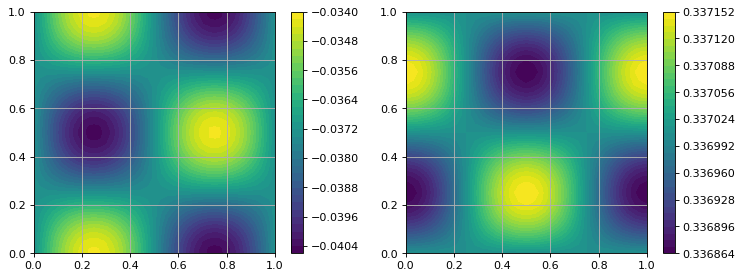

In [62]:
plt.figure(figsize = (11, 4), dpi = 80)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.colorbar(plot(u[i])); plt.grid()

In [33]:
# Save solution in VTK format
file = File("displacement.pvd");
file << u;